### A paper used as resource
Cheng F, Wu J, Fang L, Sun S, Liu B, et al. (2012) Biased Gene Fractionation and Dominant Gene Expression among the Subgenomes of Brassica rapa. PLoS ONE 7(5): e36442. doi:10.1371/journal.pone.0036442


I was interested in transcriptomics and in particular in differential analysis. This one is slightly modified because I am interested in ohnologous genes. Thus, the differential analysis will analyze a gene against its ohnologue allowing me to have for each experiment, the list of genes up-regulated against their ohnologues. For example, chromsome 3 is ohnologous with 11. So I\'m going to look if for an experiment the gene **MD13G1031100** is over or under expressed compared to its ohnologue the gene **MD16G1033300**. I did this for the 16 779 ohnologue gene pairs for 122 experiments with 3 biological replicas.

To test if we could identify an imbalance, I followed the following algorithm:
- Identification of the up-regulated genes thanks to the logFC via two fashion to consider if the gene is up-regulated compared to its ohnologue: 
        - the logFC is greater than 0, it is considered as up-regulated (known in the literature as horse race rule)
        - the logFC is higher than 2, it is considered as up-regulated (rule known in the literature as two fold rule)
- At this level for each experiment I have the number of up-regulated genes compared to their ohnologue. I then group them by chromosome pair (for example all the gene pairs linked to chromosomes 3 and 11).
- For each experiment, I am able to calculate the ratio of the number of up-regulated genes to the number of ohnologous genes for that chromosome pair. This ratio can be tested using a binomial test. 122 ratios are generated this way for each couples., allowing to construct a ratio distribution for each chromsome couple. These sets of distributions (one for the horse race rule and the other for the two fold rule) are available in the this Jupyter notebook. The color will represent the result of the binomial test.
- I also wanted to set up a test that could globally test the distribution and tell me if a couple of chromosome is transcriptionally imbalanced. To set this up, I followed the following protocol, which still raises questions about its mathematical viability:
    - For each pair of chromosomes, I will test all possible distributions to find the closest one. I will then get the mean of the distribution (loc) and the deviation (scale).
    - I will test my real distribution against a theoretical distribution with the deviation of the best distribution and an average of 50 (which would represent a ratio of 50% of the genes up regulated on one of the two chromosomes and 50% up regulated on the other side which implies no imbalance). The test I chose for this question is a Kolmogorov-Smirnov on 2 samples. The results obtained are a series of graphs at the very end of the script and a table summarizing the results of the tests for each pair of chromosomes.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import matplotlib
import numpy as np
sns.set_style("darkgrid")




In [2]:
def qualitative_column(row, column):
    if row[column] < 0.05:
        return 'significative'
    else:
        return 'NonSignificative'


In [3]:
aggregatedBinomial = pd.read_csv("../../../results/tables/aggregated_binomial.csv", index_col=0)
aggregatedChi2 = pd.read_csv("../../../results/tables/aggregated_chi2.csv", index_col=0)
aggregatedWilcoxon = pd.read_csv("../../../results/tables/aggregated_wilcoxon.csv", index_col=0)
aggregatedChi2["ratio"] = (aggregatedChi2["observed_biased1"] /(aggregatedChi2["observed_biased1"]+aggregatedChi2["observed_biased2"]))*100
aggregatedChi2 = aggregatedChi2.loc[aggregatedChi2["expected"]>100]
aggregatedChi2['significative'] = aggregatedChi2.apply(qualitative_column, args=('pval_chi2',), axis=1) 


#aggregatedBinomial = aggregatedBinomial[aggregatedBinomial["number_of_horserace_genes"]>200]
aggregatedBinomial["ratio_two_fold"] = (aggregatedBinomial["number_upregulated_genes_two_fold"] / aggregatedBinomial["number_of_two_fold_genes"]) * 100
aggregatedBinomial['significative_two_fold'] = aggregatedBinomial.apply(qualitative_column, args=('pval_two_fold_rule',), axis=1) 

aggregatedBinomial["ratio_horserace"] = (aggregatedBinomial["number_upregulated_genes_horserace"] / aggregatedBinomial["number_of_horserace_genes"]) * 100
aggregatedBinomial['significative_horserace'] = aggregatedBinomial.apply(qualitative_column, args=('pval_horse_race',), axis=1) 

aggregatedBinomialForViz = aggregatedBinomial[aggregatedBinomial["number_of_horserace_genes"]>200]


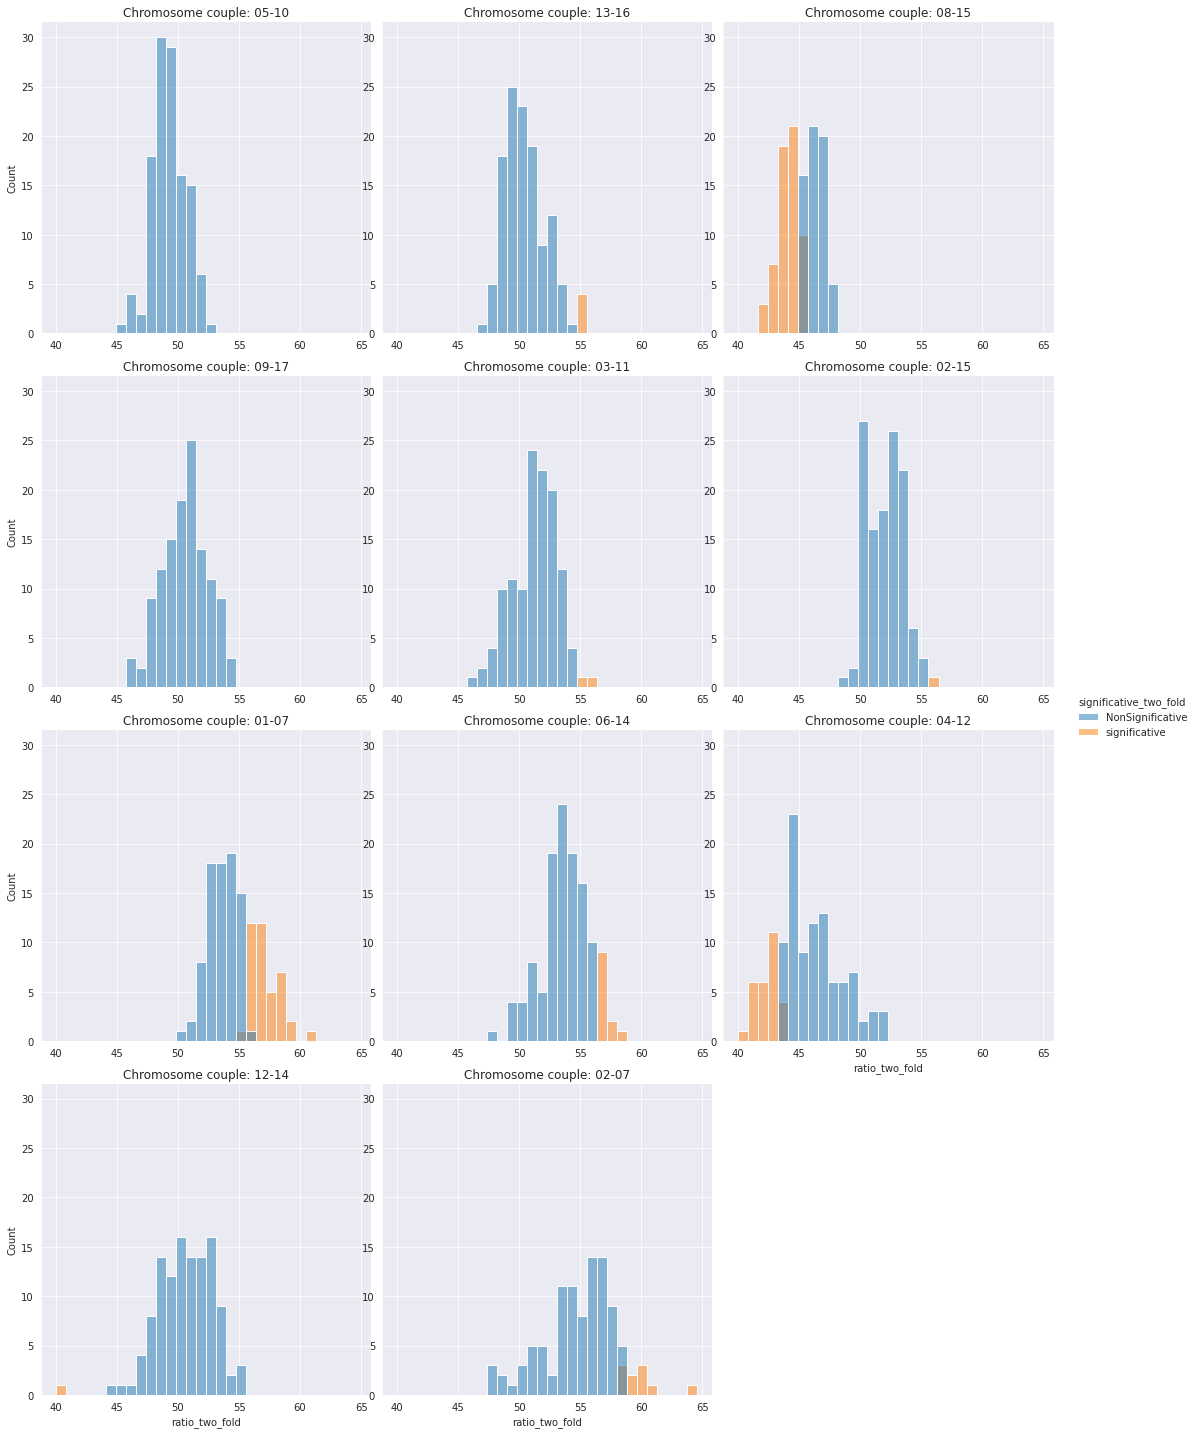

In [4]:
g = sns.displot(data=aggregatedBinomialForViz,
                x="ratio_two_fold",
                col="couple",
                hue="significative_two_fold",
                col_wrap=3)

g.set_titles(col_template = 'Chromosome couple: {col_name}', size=12)

for ax in g.axes.flat:
    _ = ax.tick_params(axis='y', labelleft=True)
    _ = ax.tick_params(axis='x', labelbottom=True)


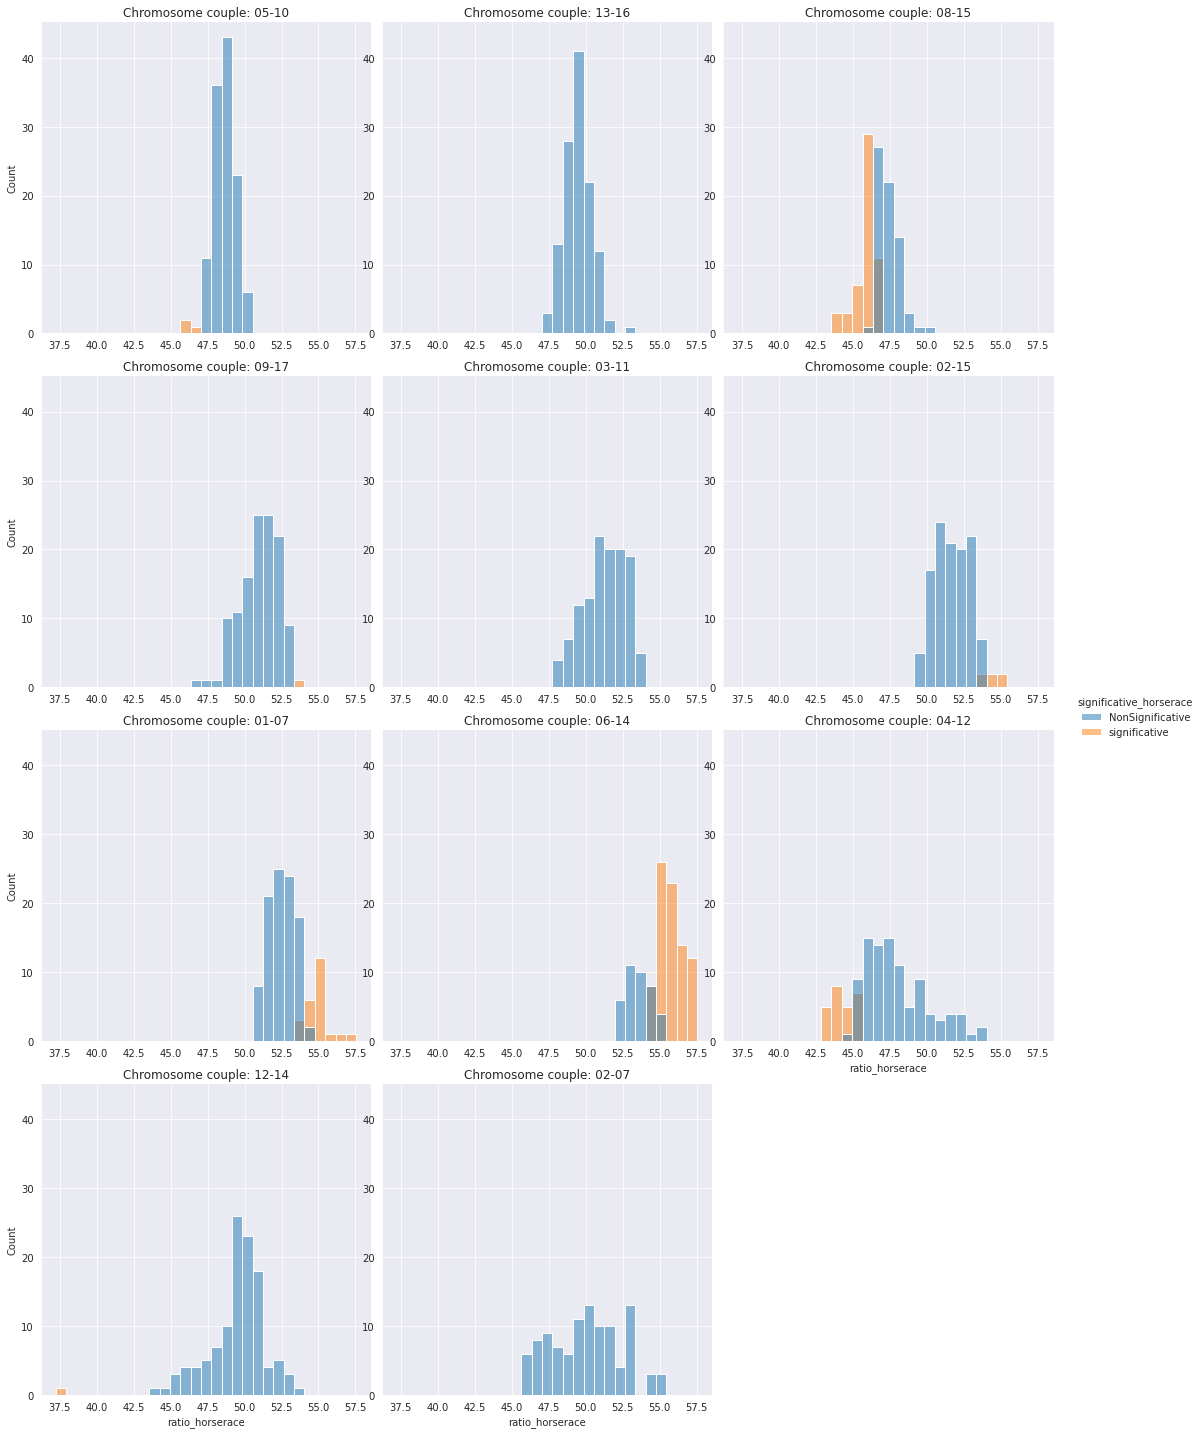

In [5]:
g = sns.displot(data=aggregatedBinomialForViz,
                x="ratio_horserace",
                col="couple",
                hue="significative_horserace",
                col_wrap=3)

g.set_titles(col_template = 'Chromosome couple: {col_name}', size=12)

for ax in g.axes.flat:
    _ = ax.tick_params(axis='y', labelleft=True)
    _ = ax.tick_params(axis='x', labelbottom=True)

In [6]:
aggregatedBinomial[aggregatedBinomial["pval_horse_race"]<0.05]

number_upregulated_genes_two_fold  number_of_two_fold_genes  \
2                                    183                       400   
11                                    59                       106   
23                                    28                        56   
50                                    26                        35   
51                                     8                        31   
...                                  ...                       ...   
17274                                138                       252   
17277                                 73                       116   
17305                                 31                        50   
17310                                 12                        40   
17329                                  8                        25   

       pval_two_fold_rule  number_upregulated_genes_horserace  \
2                0.098822                                 415   
11               0.285284                                  97   
23               1.000000                                  37   
50               0.005988                                  36   
51               0.010674                                  18   
...                   ...                                 ...   
17274            0.147229                                 208   
17277            0.006832                                 106   
17305            0.118920                                  37   
17310            0.016589                                  16   
17329            0.107752                                  10   

       number_of_horserace_genes  pval_horse_race couple  \
2                            905         0.013855  08-15   
11                           167         0.043902  06-16   
23                            94         0.049450  01-04   
50                            55         0.030029  05-09   
51                            54         0.019834  09-10   
...                          ...              ...    ...   
17274                        369         0.016519  06-14   
17277                        179         0.016525  02-07   
17305                         58         0.047940  03-07   
17310                         50         0.015347  07-11   
17329                         33         0.035082  03-13   

                     experience  ratio_two_fold significative_two_fold  \
2                SRP153563-T337       45.750000       NonSignificative   
11               SRP153563-T337       55.660377       NonSignificative   
23               SRP153563-T337       50.000000       NonSignificative   
50               SRP153563-T337       74.285714          significative   
51               SRP153563-T337       25.806452          significative   
...                         ...             ...                    ...   
17274  SRP200803-Scab-resistant       54.761905       NonSignificative   
17277  SRP200803-Scab-resistant       62.931034          significative   
17305  SRP200803-Scab-resistant       62.000000       NonSignificative   
17310  SRP200803-Scab-resistant       30.000000          significative   
17329  SRP200803-Scab-resistant       32.000000       NonSignificative   

       ratio_horserace significative_horserace  
2            45.856354           significative  
11           58.083832           significative  
23           39.361702           significative  
50           65.454545           significative  
51           33.333333           significative  
...                ...                     ...  
17274        56.368564           significative  
17277        59.217877           significative  
17305        63.793103           significative  
17310        32.000000           significative  
17329        30.303030           significative  

[672 rows x 12 columns]

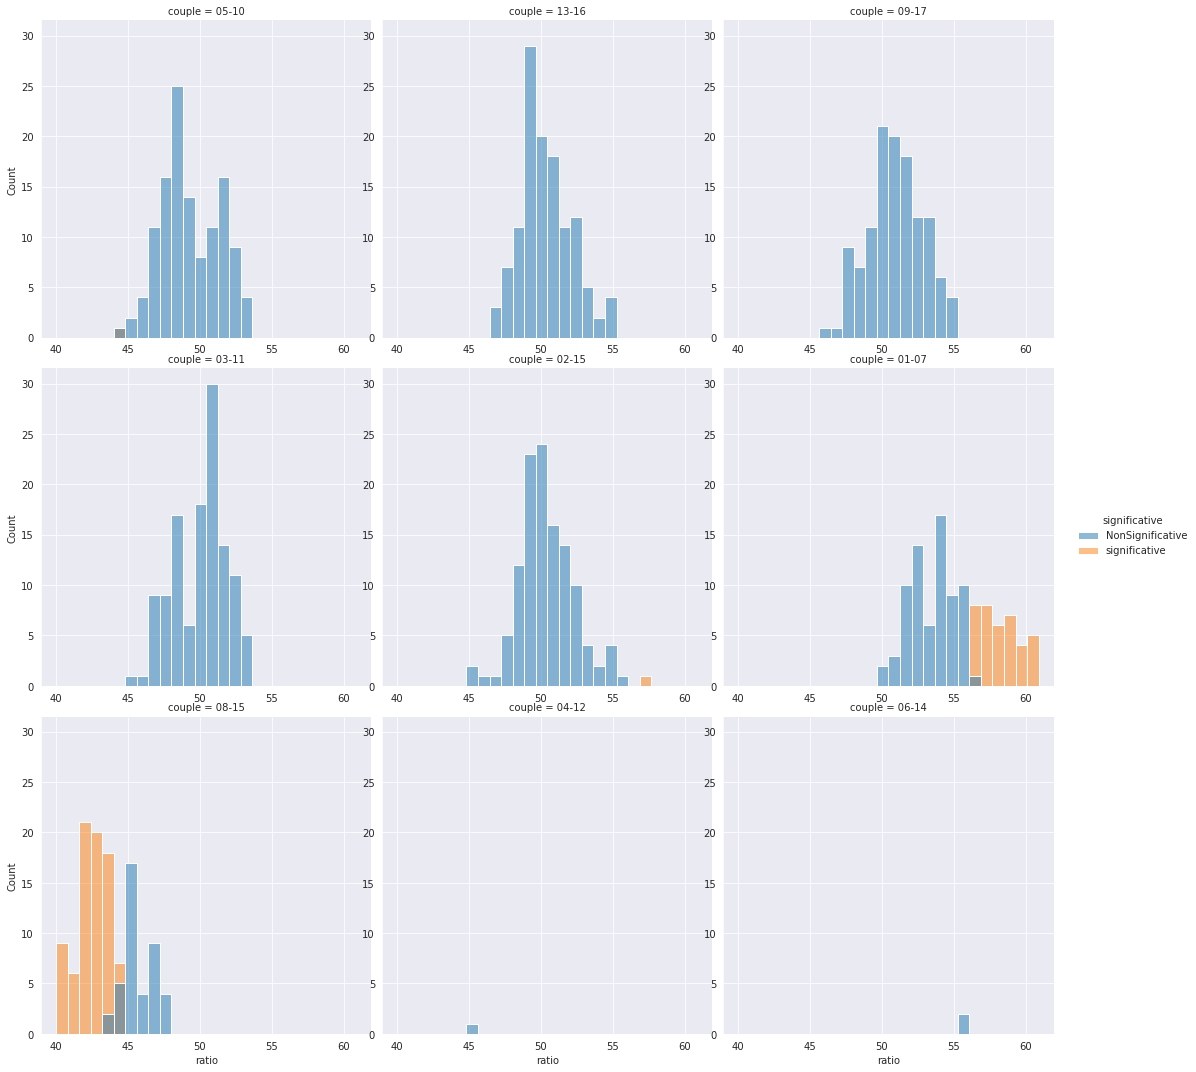

In [7]:
g = sns.displot(data=aggregatedChi2,
                x="ratio",
                col="couple",
                hue="significative",
                col_wrap=3)


for ax in g.axes.flat:
    _ = ax.tick_params(axis='y', labelleft=True)
    _ = ax.tick_params(axis='x', labelbottom=True)

In [8]:
aggregatedLogFc = pd.read_csv("../../../results/tables/logfc_aggregated.csv")

groupedLogFC = aggregatedLogFc.groupby('couple').filter(lambda x: x.shape[0] >= 100)

sizeCouple = pd.DataFrame()
for name, group in groupedLogFC.groupby("couple"):
    for name1, group1 in group.groupby("experience"):
        dic = {}
        dic["couple"] = name
        dic["experience"] = name1
        dic["size"] = group1[group1["pval_DESeq2"]<0.05].shape[0]
        sizeCouple =sizeCouple.append(dic, ignore_index=True)


medianSizeCouple = {}
for name, group in sizeCouple.groupby("couple"):
    medianSizeCouple[name] = group["size"].median()


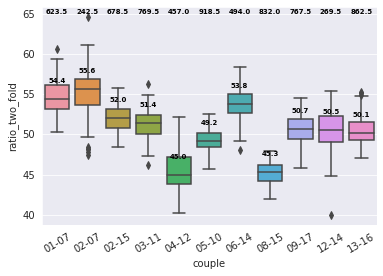

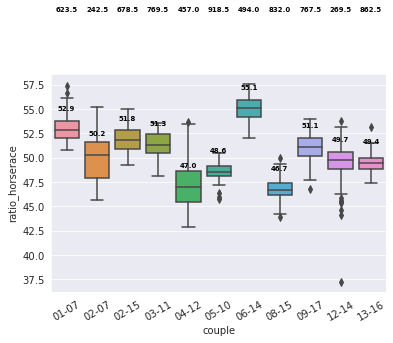

In [14]:
def add_medians_boxplot(df, box_plot, column):
    medians = df.groupby(['couple'])[column].median()
    mediansForViz = np.around(medians, decimals=1)

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      medians[xtick] + 2,
                      mediansForViz[xtick], 
                      horizontalalignment='center',
                      size='x-small',
                      color='black',
                      weight='semibold')
    return box_plot


def add_text_boxplot(df, box_plot, medianSizeCouple, column):
    medians = df.groupby(['couple'])[column].median()

    textSizeGenes = []
    for name, group in df.groupby(['couple']):
        textSizeGenes.append(medianSizeCouple[name])
    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      65,
                      textSizeGenes[xtick], 
                      horizontalalignment='center',
                      size='x-small',
                      color='black',
                      weight='semibold')
    return box_plot


order = []
for name, group in aggregatedBinomialForViz.groupby(['couple']):
    order.append(name)


g =sns.boxplot(x="couple", y="ratio_two_fold", data=aggregatedBinomialForViz, order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g = add_medians_boxplot(aggregatedBinomialForViz, g, 'ratio_two_fold')
g = add_text_boxplot(aggregatedBinomialForViz, g, medianSizeCouple, 'ratio_two_fold')

plt.show()


g = sns.boxplot(x="couple", y="ratio_horserace", data=aggregatedBinomialForViz, order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=30)
g = add_medians_boxplot(aggregatedBinomialForViz, g, "ratio_horserace")
g = add_text_boxplot(aggregatedBinomialForViz, g, medianSizeCouple, "ratio_horserace")

plt.show()



In [10]:
wholeResults = aggregatedChi2.merge(aggregatedWilcoxon, on=["couple", "experience"])
wholeResults = wholeResults.merge(aggregatedBinomial, on=["couple", "experience"])


In [11]:
globalBinomTestResults = pd.DataFrame(columns=["pVal_two_fold", "pVal_horserace", "couple"])

for name, group in aggregatedBinomialForViz.groupby(by="couple"):
    pValTwoFold = stats.binom_test(group["number_upregulated_genes_two_fold"].sum(), n=group["number_of_two_fold_genes"].sum(), p=0.5)

    pValHorserace = stats.binom_test(group["number_upregulated_genes_horserace"].sum(), n=group["number_of_horserace_genes"].sum(), p=0.5)
    ratioTwoFold = group["number_upregulated_genes_two_fold"].sum()/group["number_of_two_fold_genes"].sum()
    ratioHorseRace = group["number_upregulated_genes_horserace"].sum()/group["number_of_horserace_genes"].sum()
    tmpDict = {"pVal_two_fold":pValTwoFold, "global_ratio_two_fold":ratioTwoFold, "couple":str(group["couple"].unique()[0]), "pVal_horserace":pValHorserace, "global_ratio_horserace":ratioHorseRace}
    globalBinomTestResults = globalBinomTestResults.append(tmpDict,ignore_index=True)

display(globalBinomTestResults)

pVal_two_fold  pVal_horserace couple  global_ratio_horserace  \
0    3.672845e-84    8.409647e-59  01-07                0.529595   
1    6.708700e-34    8.949642e-01  02-07                0.499565   
2    2.222060e-19    6.183760e-26  02-15                0.518457   
3    3.951526e-09    1.935828e-14  03-11                0.512600   
4    5.318184e-52    1.049419e-35  04-12                0.473264   
5    2.545611e-04    3.738141e-21  05-10                0.485749   
6    2.301705e-41   3.584380e-131  06-14                0.550050   
7   2.046788e-113    1.847706e-96  08-15                0.467049   
8    4.163464e-03    9.560542e-09  09-17                0.509494   
9    1.788540e-01    4.456308e-02  12-14                0.494285   
10   1.082925e-02    3.912828e-04  13-16                0.494476   

    global_ratio_two_fold  
0                0.547313  
1                0.550641  
2                0.520686  
3                0.513133  
4                0.456036  
5                0.492501  
6                0.537946  
7                0.452376  
8                0.506306  
9                0.505105  
10               0.505393

In [12]:
combinedPvalOfBinom = pd.DataFrame()

for name, group in aggregatedBinomialForViz.groupby(by="couple"):
    if group.shape[0]>100:
        statHorse, pValHorse = stats.combine_pvalues(group["pval_horse_race"])
        statTwoFold, pValTwoFold = stats.combine_pvalues(group["pval_two_fold_rule"])
        tmpDict = {"combinedPval_horserace":pValHorse,
                   "combinedPval_TwoFold":pValTwoFold,
                   "couple":name}
        combinedPvalOfBinom = combinedPvalOfBinom.append(tmpDict,ignore_index=True)

combinedPvalOfBinom.sort_values(by="combinedPval_TwoFold")

combinedPval_TwoFold  combinedPval_horserace couple
7           2.760590e-59            3.483376e-46  08-15
0           3.976276e-39            1.249848e-19  01-07
4           4.682933e-18            3.157158e-15  04-12
6           3.232394e-08            1.167249e-73  06-14
1           3.371620e-07            9.999987e-01  02-07
2           6.850579e-01            2.432786e-02  02-15
3           9.835315e-01            3.362370e-01  03-11
8           9.999642e-01            9.576861e-01  09-17
10          9.999985e-01            1.000000e+00  13-16
5           1.000000e+00            5.378966e-01  05-10
9           1.000000e+00            1.000000e+00  12-14